# Calculating variance of energy

In [ ]:
%load_ext autoreload
%autoreload 2

In [88]:
import qtensor
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm.auto import tqdm

from qtensor import QtreeQAOAComposer

## Create the squared composer

In [206]:
def get_edge_subgraph_squared(G, edge1, edge2, dist):
    nodes_groups = qtensor.utils.nodes_group_by_distance(G, edge1+edge2, dist)
    all_nodes = sum(nodes_groups.values(), [])
    subgraph = G.subgraph(all_nodes).copy()
    farthest_nodes = nodes_groups[dist]
    
    edges_to_delete = []
    for u, v in subgraph.edges():
        if (u in farthest_nodes) and (v in farthest_nodes):
            edges_to_delete.append((u,v))
    subgraph.remove_edges_from(edges_to_delete)
    return subgraph

class QAOAComposerSquared(QtreeQAOAComposer):
    def cone_ansatz_squared(self, edge1, edge2):
        beta, gamma = self.params['beta'], self.params['gamma']
        
        assert(len(beta) == len(gamma))
        p = len(beta) # infering number of QAOA steps from the parameters passed
        self.layer_of_Hadamards()
        # second, apply p alternating operators
        cone_base = self.graph

        for i, g, b in zip(range(p, 0, -1), gamma, beta):
            self.graph = get_edge_subgraph_squared(cone_base, edge1, edge2, i)
            self.cost_operator_circuit(g)
            self.graph = get_edge_subgraph_squared(cone_base, edge1, edge2, i-1)
            self.mixer_operator(b)
        self.graph = cone_base


    def energy_expectation_squared(self, edge1, edge2):
        # Will need to deprecate stateful API and return the circuit
        self.cone_ansatz_squared(edge1, edge2)
        self.energy_edge(*edge1)
        self.energy_edge(*edge2)
        first_part = self.builder.circuit
        self.builder.reset()

        self.cone_ansatz_squared(edge1, edge2)
        self.builder.inverse()
        second_part = self.builder.circuit

        self.circuit = first_part + second_part
    
    def energy_expectation_lightcone_squared(self, edge1, edge2):
        G = self.graph
        gamma, beta = self.params['gamma'], self.params['beta']
        graph = get_edge_subgraph_squared(G, edge1, edge2, len(gamma))
        #print('Subgraph nodes: {}, edges: {}', graph.number_of_nodes(), graph.number_of_edges())
        self.n_qubits = graph.number_of_nodes()
        mapping = {v:i for i, v in enumerate(graph.nodes())}
        graph = nx.relabel_nodes(graph, mapping, copy=True)

        edge1 = mapping[edge1[0]], mapping[edge1[1]]
        edge2 = mapping[edge2[0]], mapping[edge2[1]]
        composer = self._get_of_my_type(graph, beta=beta, gamma=gamma)
        composer.energy_expectation_squared(edge1, edge2)
        self.circuit = composer.circuit
        # return composer


In [207]:
def get_gb(p):
    gammabeta = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])/np.pi
    return gammabeta[:p], gammabeta[p:]
    
def get_maxcut_probs(G, p, backend=qtensor.NumpyBackend()):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, backend=backend)
    gamma, beta = get_gb(p)
    comp = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    comp.ansatz_state()
    circ = comp.circuit
    sim.optimizer = qtensor.toolbox.get_ordering_algo('naive')
    amps = sim.simulate_batch(circ, batch_vars=range(G.number_of_nodes()))
    probs = np.real(amps.conj()*amps)
    return probs

def get_maxcut_cost_dist(G, p=6):
    N = G.number_of_nodes()
    probs = get_maxcut_probs(G, p)
    print('got probs')
    bitst = np.array(np.unravel_index(range(2**N), shape=[2]*N))*2-1
    e = G.number_of_edges()
    costs = [(e-sum(sol[i]*sol[j] for i,j in G.edges))/2 for sol in bitst.T]
    costs = np.array(costs)
    print('got costs')
    distr = dict()
    for i in range(len(probs)):
        c = costs[i]
        distr.setdefault(c, 0)
        distr[c] += probs[i]
    return distr

In [210]:
G = nx.random_regular_graph(3, 12, seed=12)
p = 2
edges = list(G.edges())

In [211]:
comp = QAOAComposerSquared(G, gamma=[0.1]*p, beta=[0.2]*p)
edge_pair = edges[0], edges[2]
comp.energy_expectation_lightcone_squared(*edge_pair)

## Calculate variance

In [241]:
G = nx.random_regular_graph(3, 40, seed=12)
p = 2
edge_pair = edges[0], edges[2]

In [242]:
subgraph = get_edge_subgraph_squared(G, *edge_pair, p)

Text(0.5, 1.0, 'Subgraph on ((4, 10), (4, 7))')

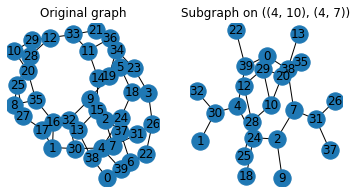

In [243]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))
plt.sca(axs[0])
nx.draw_kamada_kawai(G, with_labels=True)
plt.title(f'Original graph')
plt.sca(axs[1])
nx.draw_kamada_kawai(subgraph, with_labels=True)
plt.title(f'Subgraph on {edge_pair}')

In [235]:
cost_dist = get_maxcut_cost_dist(G, p=p)
cost_dist

got probs
got costs


{0.0: 1.4977672230511685e-11,
 3.0: 3.4254762038782153e-10,
 6.0: 1.805905772196864e-08,
 4.0: 1.4870594227461157e-09,
 7.0: 1.0800987916147559e-07,
 9.0: 1.1649199034735454e-06,
 10.0: 5.611961247292553e-06,
 12.0: 6.630321058538682e-05,
 13.0: 0.00021632062853890578,
 5.0: 1.7798192189191204e-09,
 8.0: 3.328799524568093e-07,
 11.0: 1.9953817546624668e-05,
 15.0: 0.0017361743325808286,
 16.0: 0.004739224084642502,
 14.0: 0.0006325954338114733,
 17.0: 0.01088441878489625,
 18.0: 0.022457032997677602,
 19.0: 0.04483359409383747,
 20.0: 0.08392347805681082,
 21.0: 0.1315727317931853,
 22.0: 0.1708463573821889,
 23.0: 0.1804846409624351,
 24.0: 0.161665906158013,
 25.0: 0.11475219443882308,
 26.0: 0.059517223922039716,
 27.0: 0.011643925877333459}

In [244]:
def simulate_variance(G, p=4):
    gamma, beta = get_gb(p)
    sim = qtensor.QtreeSimulator()
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    squared = 0
    pbar = tqdm(total=len(G.edges)**2)
    for e1 in G.edges:
        for e2 in G.edges:
            comp.energy_expectation_lightcone_squared(e1, e2)
            energy2 = sim.simulate_batch(comp.circuit, batch_vars=0)
            squared += energy2
            pbar.update()
    linear = 0
    for e in G.edges:
            comp.energy_expectation_lightcone(e)
            energy = sim.simulate_batch(comp.circuit, batch_vars=0)
            linear += energy
    print('lineaar', linear)
    print('squared', squared)
    E = G.number_of_edges()
    cost = 1/2*(E - linear)
    print('cost', cost)
    cost2 = 1/4*(E*E - 2*E*linear + squared)
    print('cost2', cost2)
    return cost2 - cost*cost


In [245]:
var = simulate_variance(G, p=2)
print('Variance', var)


lineaar [-30.25381134-3.52897327e-16j]
squared [952.0408833+3.90152103e-14j]
cost [45.12690567+1.76448663e-16j]
cost2 [2045.6245611+2.03407224e-14j]
Variance [9.18694564+4.41555801e-15j]


Text(0.5, 1.0, 'Cost distribution')

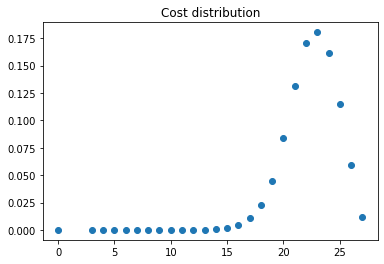

In [238]:
plt.scatter(cost_dist.keys(), cost_dist.values())
plt.title('Cost distribution')

In [239]:
pdf = np.array(list(cost_dist.values()))
x = np.array(list(cost_dist.keys()))
Z = sum(pdf)
mean = sum(pdf*x)/Z
var_direct = sum(pdf*(mean-x)**2)/Z
var_direct

4.661390875989544

In [246]:
assert np.isclose(np.real(var), var_direct), "The two don't match!"
print("The two match!")

AssertionError: The two don't match!